Obtained from [[towardsdatascience.com / Fundamental Techniques of Feature Engineering for Machine Learning](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114#83e6)]

# Recap: *Feature Engineering*

Basically, all machine learning algorithms use some input data to create outputs. This input data comprise features. Algorithms require features with some specific characteristic to work properly. Here, the need for feature engineering arises. Feature engineering efforts mainly have two goals:

+ Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
+ Improving the performance of machine learning models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from os.path import join
path_prefix = "/content/drive/My Drive"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imputation

Missing values are one of the most common problems we can encounter preparing a data for machine learning. The reason for the missing values might be human errors, interruptions in the data flow, privacy concerns, and so on.

The most simple solution to the missing values is to drop the rows or the entire column but, in this way, the data size will be smaller.

## Numerical Imputation

If we have a column that only has 1 and NA, then it is likely that the NA rows correspond to 0. For another example, if you have a column that shows the “customer visit count in last month”, the missing values might be replaced with 0 as long as you think it is a sensible solution.

Except for the case of having a default value for missing values, probably the best imputation way is to use the medians. Because the averages of the columns are sensitive to the outliers, while medians are more prone.

```
#Filling all missing values with 0
data = data.fillna(0)

#Filling missing values with medians of the columns
data = data.fillna(data.median())

#Filling missing values with means of the columns
data = data.fillna(data.mean())
```

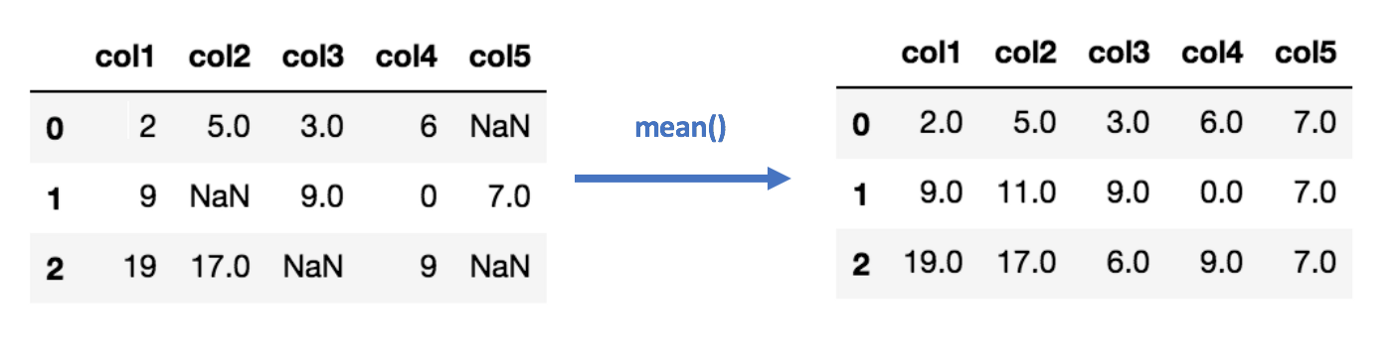

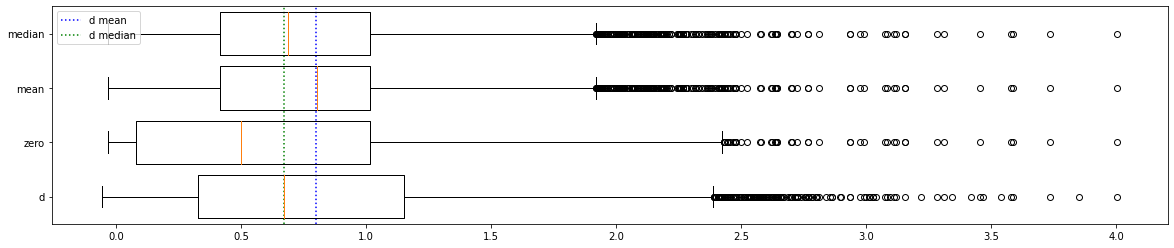

In [ ]:
from scipy.stats import skewnorm

d = pd.Series(skewnorm.rvs(50, size=10_000))

s_size = 5_000
s = pd.Series(np.hstack([
  np.random.choice(d, s_size // 10 * 8),
  np.full(s_size // 10 * 2, np.nan)
]))

plt.figure(figsize=(20, 4))
plt.boxplot(
  x=     [d,    s.fillna(0),  s.fillna(s.mean()),  s.fillna(s.median())],
  labels=["d",  "zero",       "mean",              "median"],
  vert=False, widths=0.8,
)
plt.vlines(d.mean(), 0.5, 4.5, label='d mean', colors='blue', linestyles='dotted')
plt.vlines(d.median(), 0.5, 4.5, label='d median', colors='green', linestyles='dotted')
plt.legend(loc="upper left")
plt.show()

Now, let's see how we can apply this to a real dataset.

In [ ]:
df = pd.read_csv(join(path_prefix, 'movies_metadata.csv'))
df = df[["original_title", "belongs_to_collection", "popularity", "status"]]
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,original_title,belongs_to_collection,popularity,status
0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...",21.9469,Released
1,Jumanji,NaN,17.0155,Released
2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",11.7129,Released
3,Waiting to Exhale,NaN,3.85949,Released
4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...",8.38752,Released


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   original_title         45466 non-null  object
 1   belongs_to_collection  4494 non-null   object
 2   popularity             45461 non-null  object
 3   status                 45379 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


In [ ]:
df['belongs_to_collection'].fillna(0, inplace=True)
df['belongs_to_collection'] = (df['belongs_to_collection'] != 0).astype(int) # to make 1, if they belong to collection

In [ ]:
df["popularity"] = pd.to_numeric(df['popularity'], errors='coerce', downcast="float")
df["popularity"].fillna(df["popularity"].mean(), inplace=True)

##Categorical Imputation

Replacing the missing values with the maximum occurred value in a column is a good option for handling categorical columns. However, if the values are distributed uniformly and there isn't a dominant value, imputing a category like “Other” might be more sensible, because in such a case, the imputation is likely to converge a random selection.




```
#Max fill function for categorical columns
data['column_name'].fillna(data['column_name'].value_counts().idxmax(), inplace=True)
```



In [ ]:
dic = {"Canceled":0, "Planned":1, "In Production":2, "Post Production":3, "Rumored":4, "Released":5}
df["status"] = df["status"].map(dic)

df["status"].fillna(df["status"].value_counts().idxmax(), inplace=True)

# Handling Outliers

## Outlier Detection with Standard Deviation

If a value has a distance to the average higher than $x * \sigma$, it can be assumed as an outlier. Then what $x$ should be? While there is no trivial solution for $x$, usually a value between 2 and 4 is practical.

```
#Dropping the outlier rows with standard deviation
factor = 3
mean = data['column'].mean()
std = data['column'].std()

upper_lim = mean + std * factor
lower_lim = mean - std * factor

data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]
```

## Outlier Detection with Percentiles

Another mathematical method to detect outliers is to use percentiles. We can assume a certain percent of the value from the top or the bottom as an outlier.

Additionally, a common mistake is using the percentiles according to the range of the data. In other words, if the data ranges from 0 to 100, top 5% is not the values between 96 and 100. Top 5% means here the values that are out of the 95th percentile of data.

```
#Dropping the outlier rows with Percentiles
upper_lim = data['column'].quantile(.95)
lower_lim = data['column'].quantile(.05)

data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]
```

# Scaling

In most cases, the numerical features of the dataset don't have a certain range and they differ from each other. In real life, we do not expect age and income to have the same range. From the machine learning point of view, how these two columns can be compared?

Scaling solves this problem. The continuous features become identical in terms of the range, after a scaling process. This process is not mandatory for many algorithms, but it might be still nice to apply.

Basically, there are two common ways of scaling: *Normalization* and *Standardization*

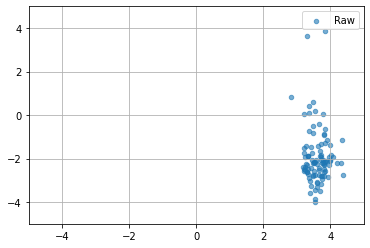

In [ ]:
def scatter(x, y, label):
  ax = plt.gca()
  ax.scatter(x, y, alpha=0.6, s=20, label=label)
  ax.set_xbound(-5, 5)
  ax.set_ybound(-5, 5)
  ax.grid()
  ax.legend()

# Raw data
n = 100
df = pd.DataFrame({
    "x": 3.6 + np.random.randn(n) * 0.3,
    "y": -1.9 + np.random.randn(n) ** 2 * 0.8 - skewnorm.rvs(50, size=n)
})

scatter(df["x"], df["y"], "Raw")

## Normalization

Normalization (or min-max normalization) scale all values in a fixed range between 0 and 1. This transformation does not change the distribution of the feature and due to the decreased standard deviations, the effects of the outliers increases. Therefore, before normalization, it is recommended to handle the outliers.

$\large{X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}}}$

```
data = pd.DataFrame({'value':[2,45, -23, 85, 28, 2, 35, -12]})
min = data['value'].min()
max = data['value'].max()

data['normalized'] = (data['value'] - min) / (max - min)

   value  normalized
0      2        0.23
1     45        0.63
2    -23        0.00
3     85        1.00
4     28        0.47
5      2        0.23
6     35        0.54
7    -12        0.10
```

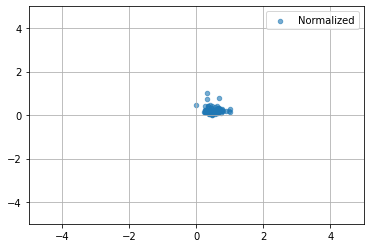

In [ ]:
def normalize(x):
  min = x.min()
  max = x.max()
  return (x - min) / (max - min)

scatter(normalize(df["x"]), normalize(df["y"]), "Normalized")

##Standardization

Standardization (or z-score normalization) scales the values while taking into account standard deviation. If the standard deviation of features is different, their range also would differ from each other. This reduces the effect of the outliers in the features.

In the following formula of standardization, the mean is shown as $\mu$ and the standard deviation is shown as $\sigma$.

$\large{z=\frac{x-\mu}{\sigma}}$

```
data = pd.DataFrame({'value':[2,45, -23, 85, 28, 2, 35, -12]})
mean = data['value'].mean()
std = data['value'].std()

data['standardized'] = (data['value'] - mean) / std

   value  standardized
0      2         -0.52
1     45          0.70
2    -23         -1.23
3     85          1.84
4     28          0.22
5      2         -0.52
6     35          0.42
7    -12         -0.92
```

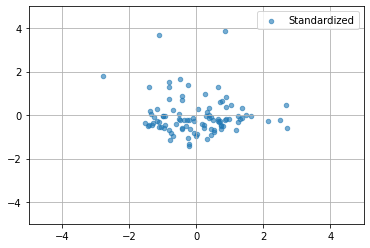

In [ ]:
def standardize(x):
  mean = x.mean()
  std = np.std(x)
  return (x - mean) / std

scatter(standardize(df["x"]), standardize(df["y"]), "Standardized")

In comparison:

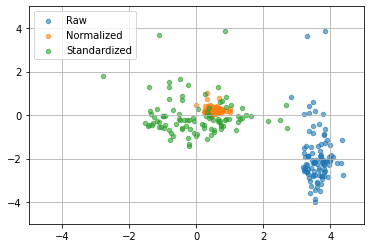

In [ ]:
scatter(df["x"], df["y"], "Raw")
scatter(normalize(df["x"]), normalize(df["y"]), "Normalized")
scatter(standardize(df["x"]), standardize(df["y"]), "Standardized")